In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split, learning_curve, validation_curve, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

In [3]:
def get_accuracy(model):

    print('-' * 80)
    print(f'\nMODEL: {model}\n')

    # Get sklearn accuracy score for given model; e.g., https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB.score
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    print(f'[*] Train Score: {str(train_score)}')
    print(f'[*] Test Score: {str(test_score)}')

    y_pred = model.predict(X_test)
    print('\n[*] Test Classification Report: \n', metrics.classification_report(y_test, y_pred))

    print('[*] Confusion Matrix on Test data')
    '''
    metrics.ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=list(range(2)), # length of unique values for label
    )
    '''
    cm = metrics.confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()

    print(f'[*] Test Accuracy: {str(round(test_score, 5) * 100)}%')
    print('-' * 80 + '\n')

def select_optimal_model_parameters(default_model, gridsearch_model):
    """ Calculates accuracy for the default and Gridsearch nominated parameters and appends the model with the highest accuracy to the model evaluation list """
    # save for selection comparison against GridSearch nomination
    y_pred = default_model.predict(X_test)
    default_model_acc = metrics.accuracy_score(y_test, y_pred) *100

    y_pred = gridsearch_model.predict(X_test)
    gridsearch_model_acc = metrics.accuracy_score(y_test, y_pred) *100

    # Compare the default and GridSearch paramaters for highest accuracy model to append to evaluation list
    if default_model_acc >= gridsearch_model_acc:
        print('Default parameter model selected')
        models.append(default_model)
    else:
        print('Gridsearch parameter model selected')
        models.append(gridsearch_model)

In [4]:
def plot_learning_curve(estimator, X, y, train_sizes, cv):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, train_sizes=train_sizes, cv=cv, scoring='accuracy', n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training Score')
    plt.plot(train_sizes, test_scores_mean, label='Cross-Validation Score')
    plt.title('Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy Score')
    plt.legend()
    plt.show()

def plot_validation_curve(clf, X_train, y_train, param_name, cv):
    # Define the hyperparameter range
    param_range = np.arange(1, 21)

    # Calculate training and validation scores over the specified hyperparameter range
    train_scores, test_scores = validation_curve(
        clf, X_train, y_train, param_name=param_name, param_range=param_range,
        cv=cv, scoring="accuracy", n_jobs=-1
    )

    # Plot the validation curve
    plt.figure(figsize=(10, 6))
    plt.plot(param_range, np.mean(train_scores, axis=1), label='Training Score')
    plt.plot(param_range, np.mean(test_scores, axis=1), label='Validation Score')
    plt.title('Model Complexity Graph')
    plt.xlabel(f'{param_name}')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [20]:
models = []
file_path = "Obfuscated-MalMem2022.csv"
data = pd.read_csv(file_path)
# data.head()
# data.describe().T
# data.info()
data.drop(['handles.nport', 'pslist.nprocs64bit', 'svcscan.interactive_process_services'], axis=1, inplace=True)
data = data.sample(n=40000, random_state=42)


data['Class'].replace({'Benign':0, 'Malware':1}, inplace=True)
data[['Cat1', 'Cat2']] = data['Category'].str.extract('(\w+)-(\w+)-.*', expand=True).fillna('Benign')
label_encoder = LabelEncoder()
data['Cat1'] = label_encoder.fit_transform(data['Cat1'])
data['Cat2'] = label_encoder.fit_transform(data['Cat2'])

# correlation_matrix = data.corr()
# plt.figure(figsize=(40,40))
# sns.heatmap(correlation_matrix, annot=True, center=0)

data.drop(['Category'], axis=1, inplace=True)

correlations = []
for feature in data.columns:
    corr = data['Class'].corr(data[feature]) * 100
    abs_corr = abs(corr)
    correlations.append(abs_corr)
y = sorted(correlations)
X = [x for x in range(len(y))]
mean = np.mean(correlations)
fourth_quant = np.quantile(correlations, 0.75)
high_correlation_threshold = fourth_quant # equals 74

hc_features = []
for feature in data.columns:
    corr = data['Class'].corr(data[feature]) * 100
    abs_corr = abs(corr)
    if abs_corr > high_correlation_threshold:
        hc_features.append(feature)
hc_data = pd.DataFrame(data[hc_features])
# hc_data.info()
features=hc_data.columns
scaled_ds=pd.DataFrame(hc_data, columns=hc_data.columns)
for feature in features:
    Q1 = scaled_ds[feature].quantile(0.25)
    Q3 = scaled_ds[feature].quantile(0.75)
    IQR = Q3 - Q1

    scaled_ds = scaled_ds[~((scaled_ds[feature] < (Q1 - 1.5 * IQR)) | (scaled_ds[feature] > (Q3 + 1.5 * IQR)))]

X = scaled_ds[features]
y = scaled_ds['Class']

# X=pd.DataFrame(data)
# X.drop(['Class','Cat1','Cat2'],axis=1,inplace=True)
# y=pd.DataFrame(data['Class'])

In [21]:
print(X.head(1))
print(y)

      pslist.avg_threads  dlllist.ndlls  dlllist.avg_dlls_per_proc  \
8586           12.817887           2018                      50.45   

      handles.nevent  handles.nthread  handles.nsemaphore  handles.ntimer  \
8586            4082             1098                 727             142   

      handles.nsection  handles.nmutant  ldrmodules.not_in_load  \
8586               364              351                      60   

      ldrmodules.not_in_mem  svcscan.process_services  Class  Cat1  
8586                     60                        27      0     0  
8586     0
26117    1
5018     0
36706    1
17751    0
        ..
17586    0
31110    1
27202    1
1970     0
11302    0
Name: Class, Length: 38750, dtype: int64


In [22]:
class_counts=y.value_counts()
print(class_counts)

Class
0    20370
1    18380
Name: count, dtype: int64


In [23]:
class_ratios=class_counts/len(y)
print(class_ratios)

Class
0    0.525677
1    0.474323
Name: count, dtype: float64


<Axes: >

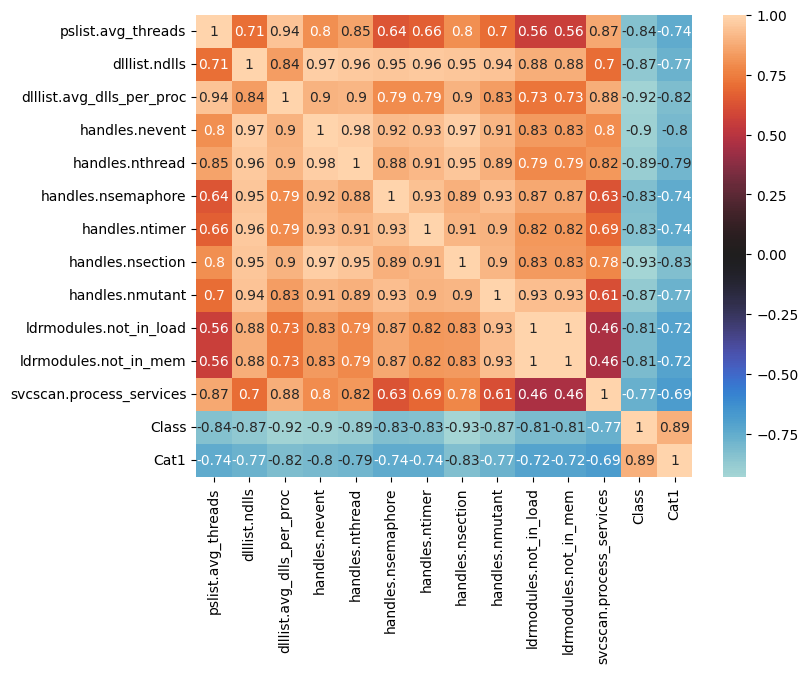

In [26]:
# Get correlation for the feautes within the data dataframe
correlation_matrix = X.corr()

# Plot the associated feature correlation using seaborn's heatmap
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, center=0)

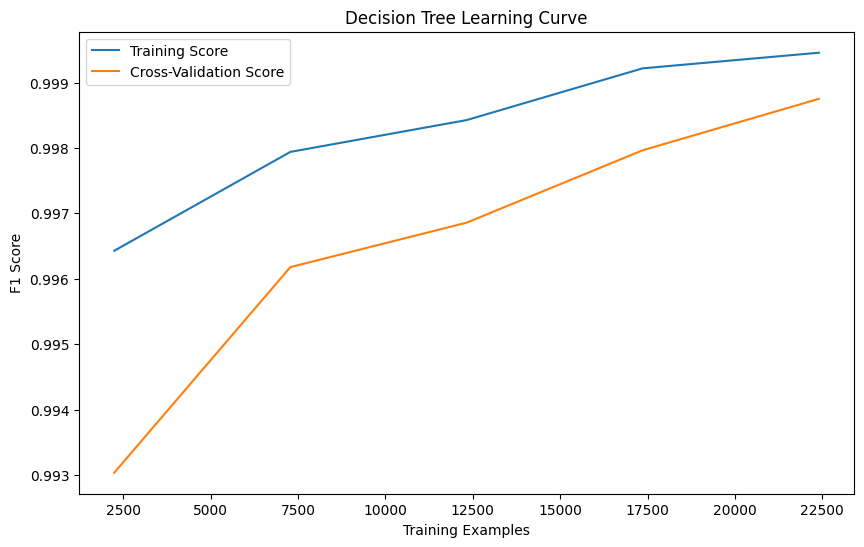

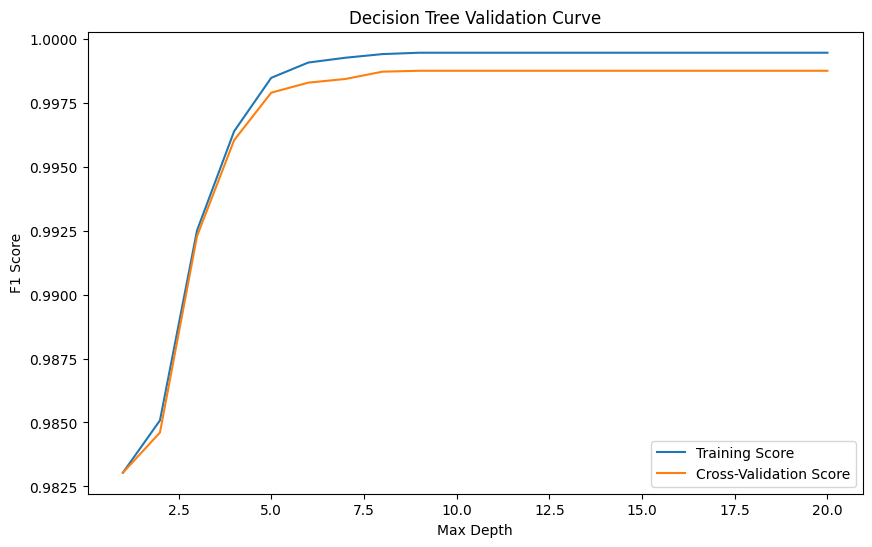

Accuracy on Test Set: 0.9997
F1 Score on Test Set: 0.9997
--------------------------------------------------------------------------------

MODEL: DecisionTreeClassifier(max_features='sqrt', min_samples_leaf=5,
                       min_samples_split=10, random_state=42)

[*] Train Score: 0.9995714285714286
[*] Test Score: 0.9994166666666666

[*] Test Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6214
           1       1.00      1.00      1.00      5786

    accuracy                           1.00     12000
   macro avg       1.00      1.00      1.00     12000
weighted avg       1.00      1.00      1.00     12000

[*] Confusion Matrix on Test data


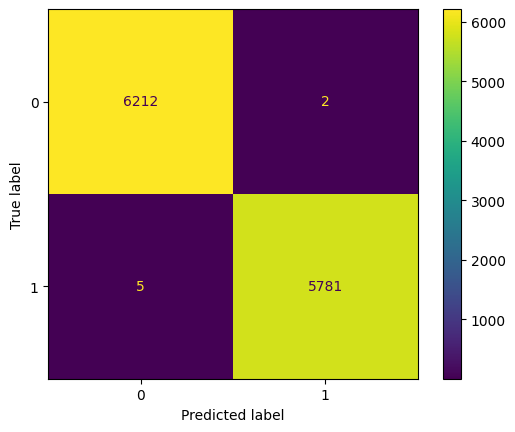

[*] Test Accuracy: 99.942%
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

MODEL: DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features='log2',
                       random_state=42)

[*] Train Score: 0.9998214285714285
[*] Test Score: 0.9996666666666667

[*] Test Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6214
           1       1.00      1.00      1.00      5786

    accuracy                           1.00     12000
   macro avg       1.00      1.00      1.00     12000
weighted avg       1.00      1.00      1.00     12000

[*] Confusion Matrix on Test data


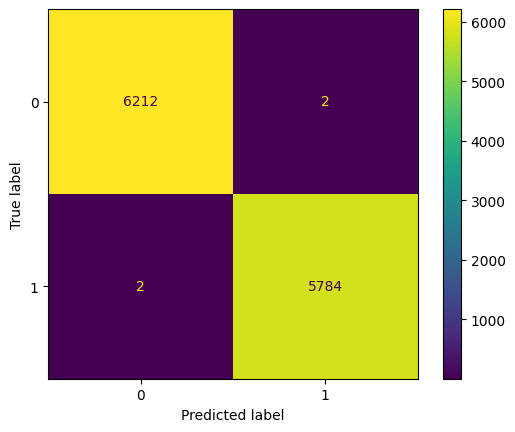

[*] Test Accuracy: 99.967%
--------------------------------------------------------------------------------

Gridsearch parameter model selected
Total time taken : 0.10 seconds


In [73]:
import time
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn.preprocessing import MinMaxScaler

# Instantiate the scaler
scaler = MinMaxScaler()
scaler.fit(X_train)

# T
X_train[X_train.columns] = scaler.transform(X_train[X_train.columns])
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])

# Impacted accuracy when changed, implies model were sensitive to less distance (-1 to 1 vs. 0 to 1)
# Using manual replacement instead
y_train.replace(-1.0, 0, inplace=True)
y_test.replace(-1.0, 0, inplace=True)

clf = DecisionTreeClassifier(max_features='sqrt', min_samples_split=10, min_samples_leaf=5, random_state=42)
clf.fit(X_train, y_train)

end_time = time.time()

# Plot learning curve
train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, train_sizes=40000, cv=5, scoring='accuracy', n_jobs=-1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-Validation Score')
plt.title('Decision Tree Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# Plot validation curve for max_depth
param_range = np.arange(1, 21)
train_scores, test_scores = validation_curve(clf, X_train, y_train, param_name="max_depth", param_range=param_range, cv=5, scoring="accuracy", n_jobs=-1)

plt.figure(figsize=(10, 6))
plt.plot(param_range, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(param_range, np.mean(test_scores, axis=1), label='Cross-Validation Score')
plt.title('Decision Tree Validation Curve')
plt.xlabel('Max Depth')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# Fit the final model with the optimal max_depth
optimal_max_depth = param_range[np.argmax(np.mean(test_scores, axis=1))]
final_clf = DecisionTreeClassifier(max_depth=optimal_max_depth, random_state=42)
final_clf.fit(X_train, y_train)

# Evaluate on the test set
y_pred = final_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy on Test Set: {accuracy:.4f}")
print(f"F1 Score on Test Set: {f1:.4f}")

get_accuracy(clf)

grid_values = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Instantiate and fit the GridSearch run
grid_search = GridSearchCV(clf, param_grid=grid_values, cv=5, scoring='accuracy', n_jobs=-1).fit(X_train, y_train)
grid_search.fit(X_train, y_train)
clf_gs = grid_search.best_estimator_

# Review the GridSearch nominated optimal model parameters
grid_search.best_estimator_.get_params()

get_accuracy(clf_gs)

select_optimal_model_parameters(clf, clf_gs)

total_time = end_time-start_time
print(f"Total time taken : {total_time:.2f} seconds")

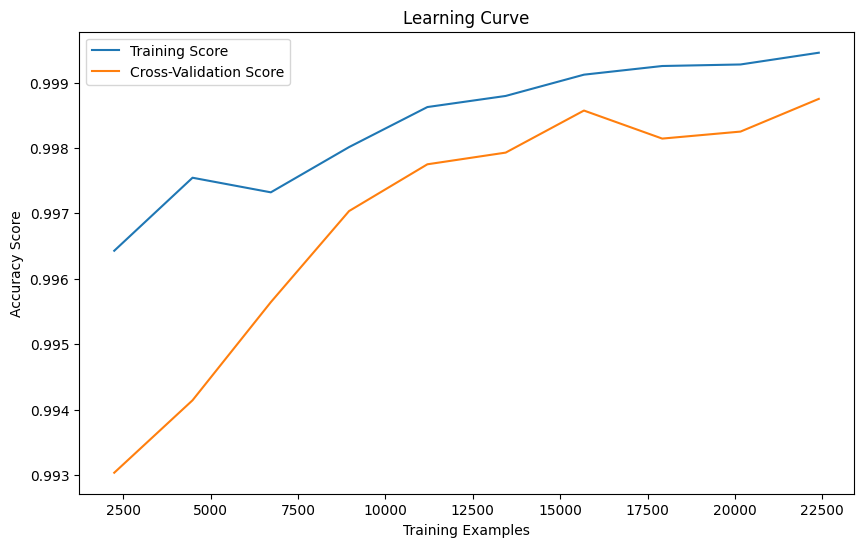

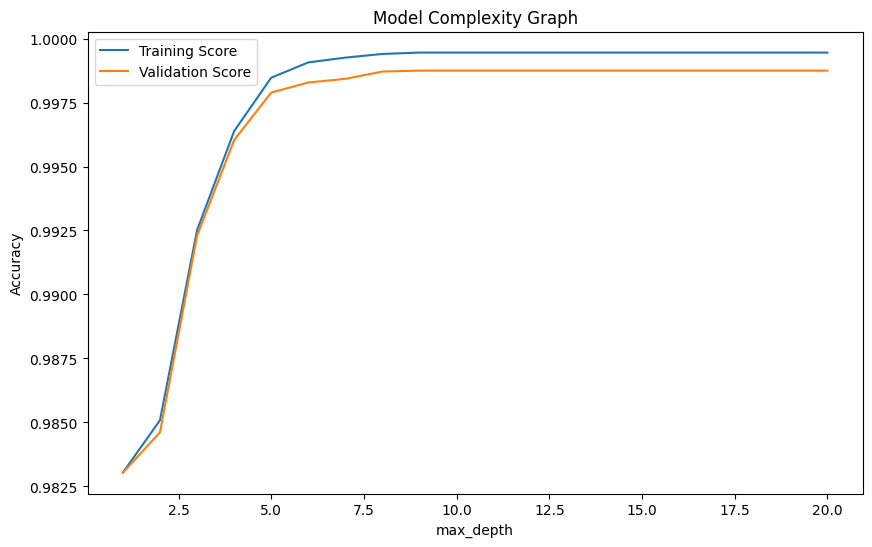

In [93]:
train_sizes = np.linspace(0.1, 1.0, 10)

# Plot the learning curve
plot_learning_curve(clf, X_train, y_train, train_sizes, cv=5)
# Plot the Validation curve
plot_validation_curve(clf,X_train, y_train,'max_depth', cv=5)

--------------------------------------------------------------------------------

MODEL: DecisionTreeClassifier()

[*] Train Score: 1.0
[*] Test Score: 0.9996666666666667

[*] Test Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6214
           1       1.00      1.00      1.00      5786

    accuracy                           1.00     12000
   macro avg       1.00      1.00      1.00     12000
weighted avg       1.00      1.00      1.00     12000

[*] Confusion Matrix on Test data


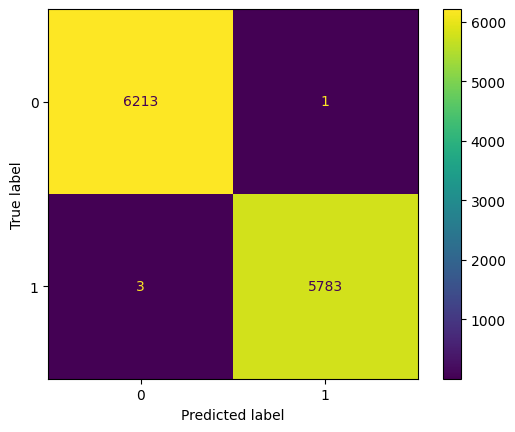

[*] Test Accuracy: 99.967%
--------------------------------------------------------------------------------

CPU times: total: 93.8 ms
Wall time: 479 ms


In [94]:
%%time

from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

#models.append(dtc)

# Display performance metrics
get_accuracy(dtc)

--------------------------------------------------------------------------------

MODEL: DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features='log2',
                       random_state=42)

[*] Train Score: 0.9998214285714285
[*] Test Score: 0.9996666666666667

[*] Test Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6214
           1       1.00      1.00      1.00      5786

    accuracy                           1.00     12000
   macro avg       1.00      1.00      1.00     12000
weighted avg       1.00      1.00      1.00     12000

[*] Confusion Matrix on Test data


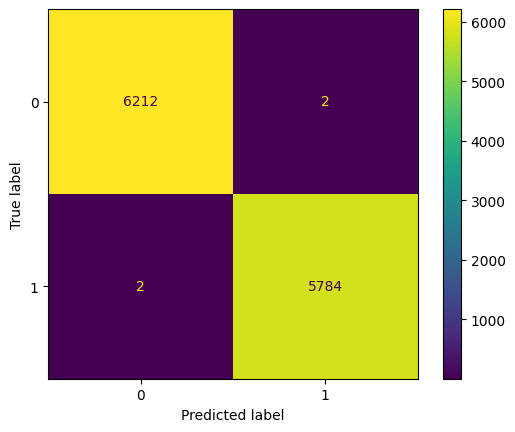

[*] Test Accuracy: 99.967%
--------------------------------------------------------------------------------

GridSearchCV Best Parameters:
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2}
CPU times: total: 27.9 s
Wall time: 2min 27s


In [85]:
%%time

grid_values = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Instantiate and fit the GridSearch run
grid_search = GridSearchCV(clf, param_grid=grid_values, cv=5, scoring='accuracy', n_jobs=-1).fit(X_train, y_train)
grid_search.fit(X_train, y_train)
clf_gs = grid_search.best_estimator_

# Review the GridSearch nominated optimal model parameters
grid_search.best_estimator_.get_params()

get_accuracy(clf_gs)
# Additional details from GridSearchCV
print("GridSearchCV Best Parameters:")
print(grid_search.best_params_)

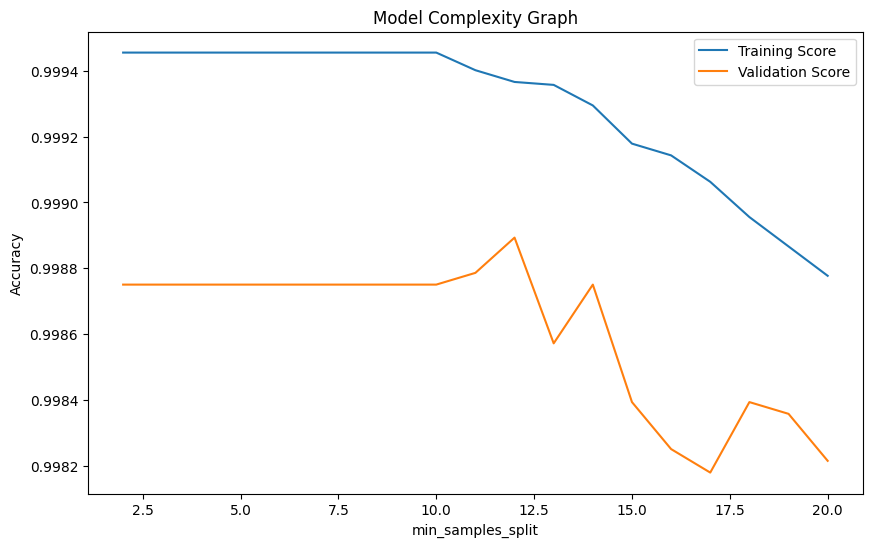

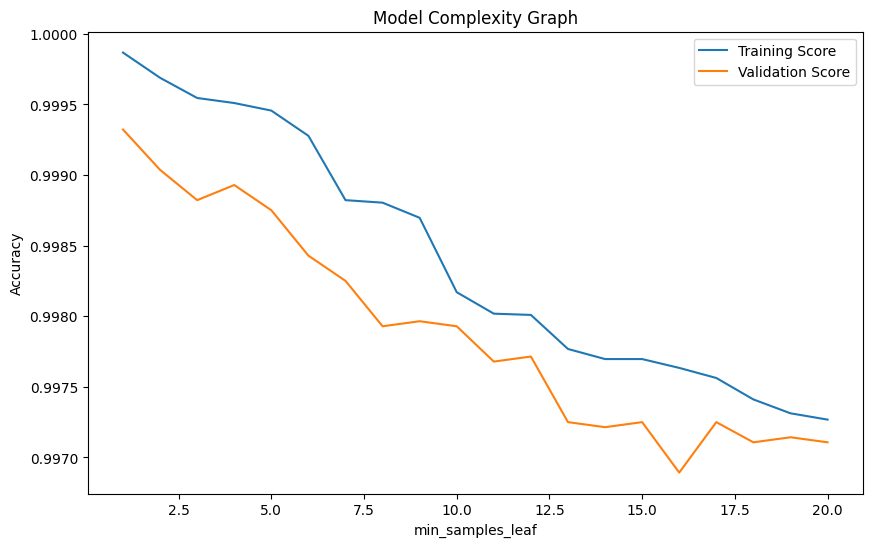

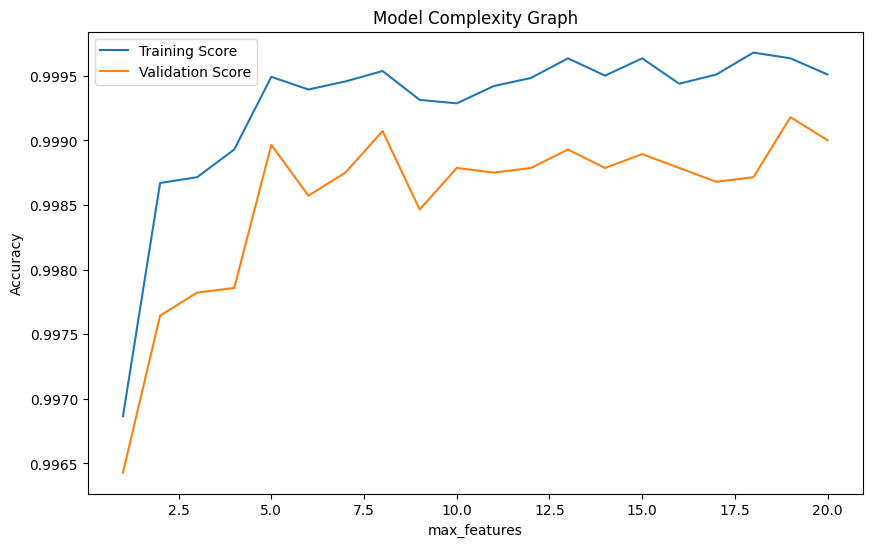

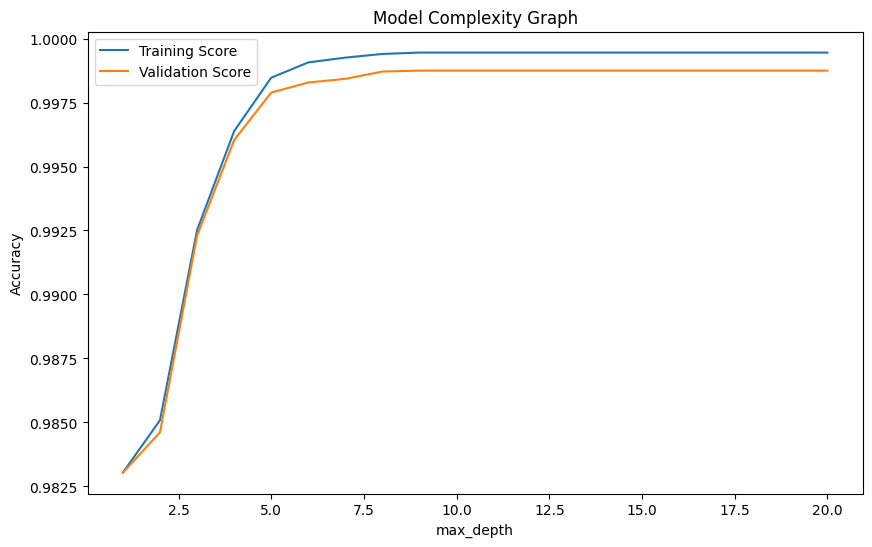

In [95]:
plot_validation_curve(clf,X_train, y_train,'min_samples_split', cv=5)
plot_validation_curve(clf,X_train, y_train,'min_samples_leaf', cv=5)
plot_validation_curve(clf,X_train, y_train,'max_features', cv=5)
plot_validation_curve(clf,X_train, y_train,'max_depth', cv=5)